In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
interval = '2h'
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False)
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [17]:
ma_candidates = [10, 20, 30, 50, 60, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]

In [4]:
# Function to backtest strategy and calculate cumulative profit
def backtest_and_calculate_profit(df, ma):
    df['Position'] = np.where(df['close'] > df[f'MA_{ma}'], 1, 0)  # 1 for buy, 0 for sell
    df['Signal'] = df['Position'].diff()  # Buy signal when diff > 0, sell signal when diff < 0

    # Initial values
    initial_cash = 10000  # Starting with $10,000
    btc_holding = 0
    cash = initial_cash
    purchase_price = 0
    # stop_loss = 0 # No stop loss    
    
    stop_loss = 0.995 # 0.5% loss
    # stop_loss = 0.99 # 1% loss
    # stop_loss = 0.98 # 2% loss
    # stop_loss = 0.97 # 3% loss

    for i in range(0, len(df)):
        price = df['close'].iloc[i]

        # Stop loss check: Sell if the price drops more than 1% below the purchase price
        if btc_holding > 0 and price < purchase_price * stop_loss:
            sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower 
            cash = btc_holding * sell_price  # Sell all BTC and hold cash
            btc_holding = 0  # No BTC left after selling
            current_time = df['timestamp'].iloc[i]
            print(f"{current_time}: Stop loss triggered! Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT")

        else:
            # Buy signal
            if df['Signal'].iloc[i] == 1:  # Crosses above MA
                # if price < df['MA_200'].iloc[i]: # 장기 이평 아래면 안 산다. -> 하락추세로 판단
                #     continue
                if cash > 0:
                    purchase_price = price #* (1 + 0.01 / 100) # buy price 0.01% higher
                    btc_holding = cash / purchase_price  # Buy BTC with all available cash
                    cash = 0  # No cash left after buying
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Bought BTC at {purchase_price:,.2f}, holding {btc_holding:.4f} BTC")

            # Sell signal
            elif df['Signal'].iloc[i] == -1:  # Crosses below MA
                if btc_holding > 0:
                    sell_price = price #* (1 - 0.01 / 100) # sell price 0.01% lower
                    cash = btc_holding * sell_price  # Sell all BTC and hold cash
                    btc_holding = 0  # No BTC left after selling
                    current_time = df['timestamp'].iloc[i]
                    print(f"{current_time}: Sold BTC at {sell_price:,.2f}, now holding {cash:,.2f} USDT\n")
        
        # Calculate current portfolio value (cash + value of BTC)
        portfolio_value = cash + (btc_holding * price)
        # Update the portfolio value for each iteration
        df.loc[i, 'portfolio_value'] = portfolio_value

    # Drop 'Signal' and 'Position' columns
    df = df.drop(columns=['Signal', 'Position'])

    # df['portfolio_value'] = portfolio_value
    # print(f"Final value for MA {ma}: {portfolio_value:,.2f} USDT")
    return df

## Test {ma} MA

In [5]:
ma = 200
profit_df = backtest_and_calculate_profit(btc_data, ma)
portfolio_value = profit_df['portfolio_value'].iloc[-1]
print(f"Final value interval {interval} for {ma} MA: {portfolio_value:,.2f} USDT")

2017-09-02 18:00:00: Bought BTC at 4,509.77, holding 2.2174 BTC
2017-09-02 20:00:00: Stop loss triggered! Sold BTC at 4,299.53, now holding 9,533.81 USDT
2017-09-02 22:00:00: Bought BTC at 4,472.14, holding 2.1318 BTC
2017-09-03 12:00:00: Stop loss triggered! Sold BTC at 4,303.10, now holding 9,173.45 USDT
2017-09-03 14:00:00: Bought BTC at 4,384.15, holding 2.0924 BTC
2017-09-04 02:00:00: Stop loss triggered! Sold BTC at 4,340.51, now holding 9,082.14 USDT
2017-09-04 08:00:00: Bought BTC at 4,336.42, holding 2.0944 BTC
2017-09-04 10:00:00: Stop loss triggered! Sold BTC at 4,153.00, now holding 8,697.98 USDT
2017-09-05 18:00:00: Bought BTC at 4,442.48, holding 1.9579 BTC
2017-09-05 20:00:00: Stop loss triggered! Sold BTC at 4,374.43, now holding 8,564.75 USDT
2017-09-25 14:00:00: Bought BTC at 3,910.01, holding 2.1905 BTC
2017-09-26 04:00:00: Stop loss triggered! Sold BTC at 3,851.00, now holding 8,435.49 USDT
2017-10-24 22:00:00: Bought BTC at 5,477.03, holding 1.5402 BTC
2017-10-25 0

## Filter 2018, 2022

In [6]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

btc_data_2022 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2022])]
btc_data_2022 = btc_data_2022.drop(btc_data_2022[~pd.to_datetime(btc_data_2022['timestamp']).dt.year.isin([2022])].index)
btc_data_2022 = btc_data_2022.reset_index(drop=True)

In [7]:
btc_data_2018.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_170,MA_180,MA_200,MA_210,MA_220,MA_230,MA_240,Position,Signal,portfolio_value
0,2018-01-01 00:00:00,13715.65,13715.65,13155.38,13203.06,827.053205,13308.122,13022.7105,13341.256000,13701.3076,...,14886.714765,15129.689667,15421.83965,15485.027048,15503.496545,15523.185696,15565.386667,0,0.0,21219.455354
1,2018-01-01 02:00:00,13203.00,13611.27,13200.00,13410.03,849.151602,13369.379,13035.7120,13303.007333,13660.3084,...,14854.656000,15098.535667,15399.38980,15472.338905,15493.184591,15510.403261,15553.395125,0,0.0,21219.455354
2,2018-01-01 04:00:00,13434.98,13699.00,13322.15,13558.99,745.036375,13473.314,13091.0675,13271.105333,13623.4882,...,14827.695235,15067.371722,15378.46430,15459.177429,15482.220409,15499.442348,15541.143000,0,0.0,21219.455354
3,2018-01-01 06:00:00,13539.00,13818.55,13510.00,13570.35,557.178461,13531.355,13153.8855,13235.427000,13611.6268,...,14798.285353,15034.634889,15358.60200,15445.941000,15471.025227,15490.321652,15527.686250,0,0.0,21219.455354
4,2018-01-01 08:00:00,13569.98,13735.24,13400.00,13616.99,484.909382,13577.260,13201.7350,13214.826667,13612.3666,...,14767.090294,15001.795944,15339.08135,15433.384571,15460.193364,15479.301565,15514.252083,0,0.0,21219.455354


In [8]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_170,MA_180,MA_200,MA_210,MA_220,MA_230,MA_240,Position,Signal,portfolio_value
0,2017-08-17 04:00:00,4261.48,4328.69,4261.32,4315.32,70.415925,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,10000.0
1,2017-08-17 06:00:00,4330.29,4349.99,4287.41,4349.99,11.672940,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,10000.0
2,2017-08-17 08:00:00,4333.32,4445.78,4333.32,4444.00,11.736430,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,10000.0
3,2017-08-17 10:00:00,4441.10,4485.39,4399.81,4427.30,51.883452,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,10000.0
4,2017-08-17 12:00:00,4436.06,4459.00,4411.00,4459.00,54.344834,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,10000.0


## Test all ma candidates

In [9]:
portfolio_value_by_ma = {}
for ma in ma_candidates:
    profit = backtest_and_calculate_profit(btc_data, ma)
    portfolio_value_by_ma[ma] = profit['portfolio_value'].iloc[-1]

2017-08-18 08:00:00: Bought BTC at 4,304.15, holding 2.3233 BTC
2017-08-18 12:00:00: Sold BTC at 4,293.09, now holding 9,974.30 USDT

2017-08-19 18:00:00: Bought BTC at 4,076.12, holding 2.4470 BTC
2017-08-20 12:00:00: Sold BTC at 4,063.35, now holding 9,943.06 USDT

2017-08-20 14:00:00: Bought BTC at 4,125.00, holding 2.4104 BTC
2017-08-20 22:00:00: Stop loss triggered! Sold BTC at 4,086.29, now holding 9,849.75 USDT
2017-08-21 20:00:00: Bought BTC at 4,039.10, holding 2.4386 BTC
2017-08-21 22:00:00: Stop loss triggered! Sold BTC at 4,016.00, now holding 9,793.42 USDT
2017-08-22 08:00:00: Bought BTC at 3,904.56, holding 2.5082 BTC
2017-08-22 10:00:00: Stop loss triggered! Sold BTC at 3,866.48, now holding 9,697.90 USDT
2017-08-22 12:00:00: Bought BTC at 3,920.99, holding 2.4733 BTC
2017-08-22 14:00:00: Stop loss triggered! Sold BTC at 3,858.23, now holding 9,542.68 USDT
2017-08-22 16:00:00: Bought BTC at 3,943.00, holding 2.4202 BTC
2017-08-23 18:00:00: Sold BTC at 4,117.07, now holdi

In [10]:
print (f"interval: {interval}")

for ma, value in portfolio_value_by_ma.items():
    print(f"Final value for MA {ma}: {value:,.2f} USDT") 

# Find the MA with the highest portfolio value
best_ma = max(portfolio_value_by_ma, key=portfolio_value_by_ma.get)
best_value = portfolio_value_by_ma[best_ma]

print(f"The best performing for {interval} is {best_ma} MA with a final portfolio value of {best_value:,.2f} USDT")


interval: 2h
Final value for MA 10: 39,377.48 USDT
Final value for MA 20: 43,675.16 USDT
Final value for MA 30: 232,545.46 USDT
Final value for MA 50: 285,142.14 USDT
Final value for MA 60: 344,407.12 USDT
Final value for MA 90: 310,700.79 USDT
Final value for MA 100: 238,351.19 USDT
Final value for MA 110: 319,511.17 USDT
Final value for MA 120: 222,113.88 USDT
Final value for MA 130: 211,800.75 USDT
Final value for MA 140: 209,658.45 USDT
Final value for MA 150: 136,206.69 USDT
Final value for MA 160: 141,452.92 USDT
Final value for MA 170: 112,553.99 USDT
Final value for MA 180: 115,964.71 USDT
Final value for MA 200: 188,185.88 USDT
Final value for MA 210: 274,884.53 USDT
Final value for MA 220: 240,578.95 USDT
Final value for MA 230: 357,759.72 USDT
Final value for MA 240: 383,398.62 USDT
The best performing for 2h is 240 MA with a final portfolio value of 383,398.62 USDT


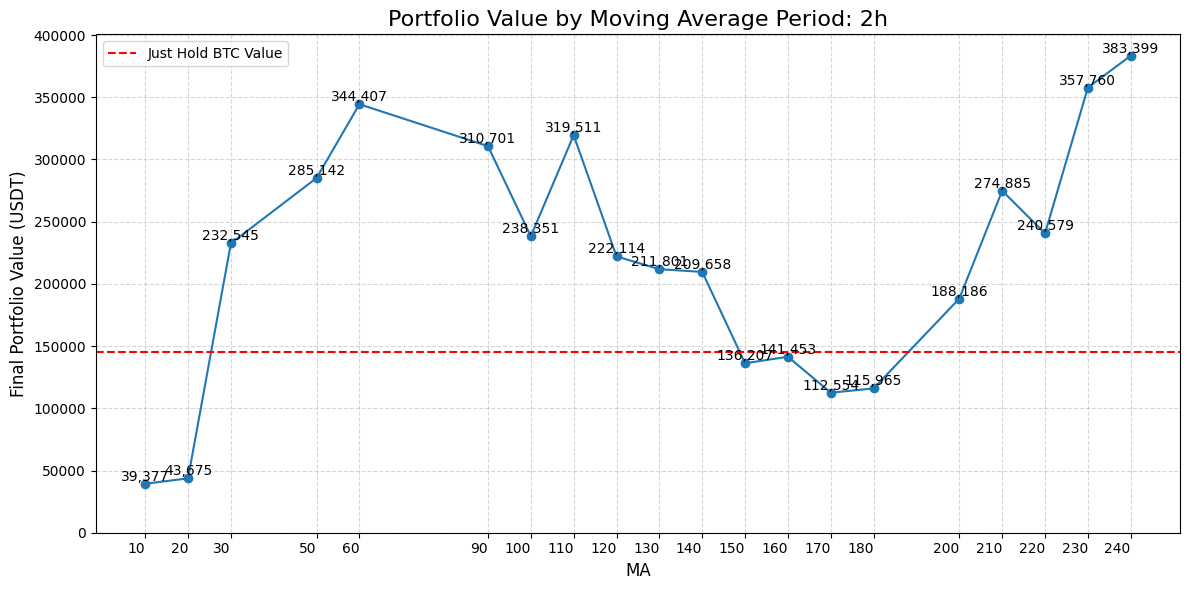

In [11]:
# Sort the dictionary by MA values
sorted_portfolio_value = dict(sorted(portfolio_value_by_ma.items()))

# Extract MA values and corresponding portfolio values
ma_values = list(sorted_portfolio_value.keys())
portfolio_values = list(sorted_portfolio_value.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(ma_values, portfolio_values, marker='o')

# Customize the plot
plt.title(f'Portfolio Value by Moving Average Period: {interval}', fontsize=16)
plt.xlabel('MA', fontsize=12)
plt.ylabel('Final Portfolio Value (USDT)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add value labels on top of each point
for i, value in enumerate(portfolio_values):
    plt.text(ma_values[i], value, f'{value:,.0f}', ha='center', va='bottom')

# Add x-axis labels for each MA value
plt.xticks(ma_values, [f'{ma}' for ma in ma_values], rotation=0, ha='right')

# Adjust the bottom margin to accommodate the labels
plt.subplots_adjust(bottom=0.2)

# Add a horizontal line at 145,580.15
plt.axhline(y=145580.15, color='red', linestyle='--', label='Just Hold BTC Value')
plt.legend()

# Adjust y-axis to start from 0
plt.ylim(bottom=0)

# Show the plot
plt.tight_layout()
plt.show()


## Just holding BTC


In [12]:
# Function to calculate final value of holding BTC
def calculate_holding_value(df):
    initial_cash = 10000  # Start with $10,000 in cash

    # Buy BTC at the first available price
    initial_price = df['close'].iloc[0]
    btc_holding = initial_cash / initial_price  # Buy BTC with all available cash

    # Sell BTC at the last available price
    final_price = df['close'].iloc[-1]
    final_value = btc_holding * final_price  # Calculate the value of the BTC holding

    print(f"Initial BTC price: {initial_price:.2f} USDT")
    print(f"Final BTC price: {final_price:.2f} USDT")
    print(f"Final value of holding BTC: {final_value:,.2f} USDT")
    
    return final_value

In [13]:

# Example usage
# Assuming 'df' is a DataFrame with your historical price data (e.g., 1-hour BTC/USDT prices)
final_value = calculate_holding_value(btc_data)

Initial BTC price: 4315.32 USDT
Final BTC price: 65502.42 USDT
Final value of holding BTC: 151,790.41 USDT


## Portfolio cumulative profit

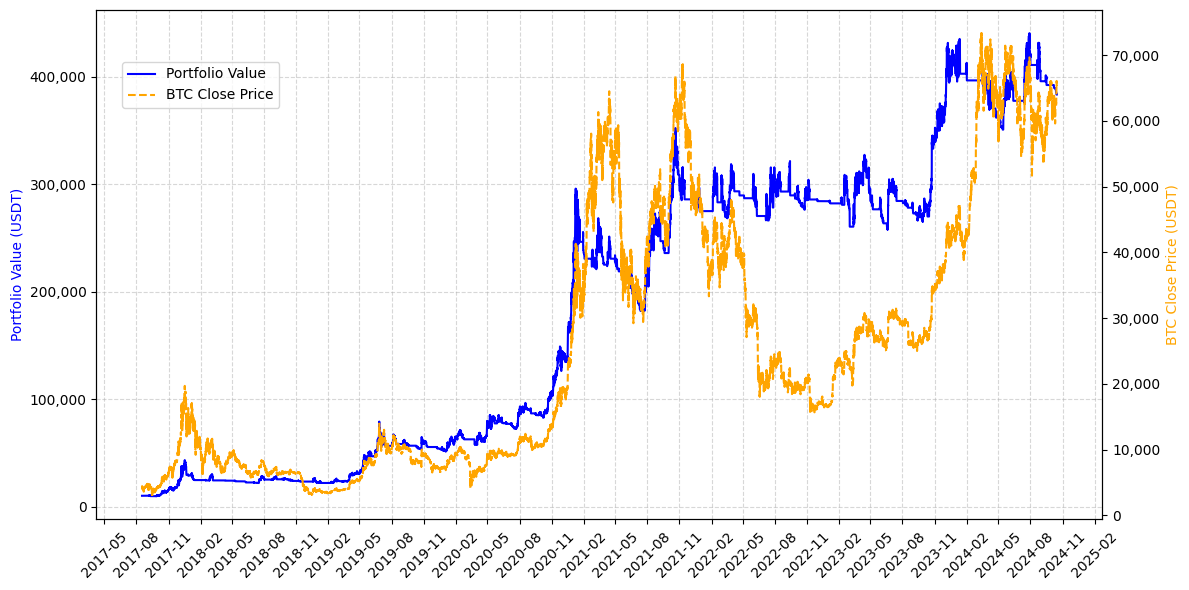

In [14]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the portfolio value over time on the left y-axis
ax1.plot(btc_data['timestamp'], btc_data['portfolio_value'], label='Portfolio Value', color='blue')

# Set x-axis ticks to show every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set the y-axis label for portfolio value
ax1.set_ylabel('Portfolio Value (USDT)', color='blue')

# Format y-axis tick labels with commas on the left axis
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Enable grid for left axis
ax1.grid(True, linestyle='--', alpha=0.5)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the BTC close price on the right y-axis
ax2.plot(btc_data['timestamp'], btc_data['close'], label='BTC Close Price', color='orange', linestyle='--')

# Set the y-axis label for BTC close price
ax2.set_ylabel('BTC Close Price (USDT)', color='orange')

# Optionally, format the y-axis on the right if needed (e.g., formatting for currency)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas

# Add a legend for both plots
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent cutting off labels
fig.tight_layout()

# Show the plot
plt.show()

In [15]:
# Filter btc_data for the year 2018 and 2022
btc_data_2018 = btc_data[pd.to_datetime(btc_data['timestamp']).dt.year.isin([2017, 2018])]
btc_data_2018 = btc_data_2018.drop(btc_data_2018[~pd.to_datetime(btc_data_2018['timestamp']).dt.year.isin([2017, 2018])].index)
btc_data_2018 = btc_data_2018.reset_index(drop=True)

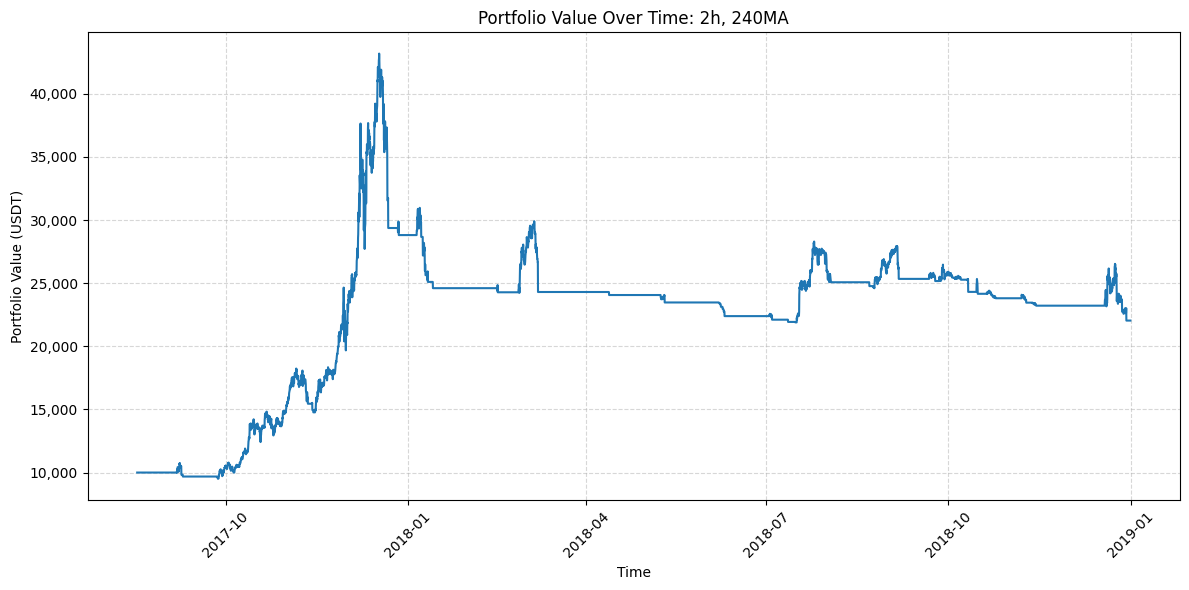

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime

# Create a new figure with a specific size
plt.figure(figsize=(12, 6))

# Plot the portfolio value over time
plt.plot(btc_data_2018['timestamp'], btc_data_2018['portfolio_value'], label='Portfolio Value')
plt.gca().autoscale()

# Set x-axis limits to show only 2017
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 12, 31)
# plt.xlim(start_date, end_date)

# Set x-axis ticks to show every 3 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Tick every 3 months

# Format the x-axis to show Year-Month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate the x-ticks for readability
plt.xticks(rotation=45)

# Set y-axis limits
# plt.ylim(-100000, 1300000)

# Set y-axis ticks to every 100,000 units
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100000))  # Tick every 100k

# Format y-axis tick labels with commas
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format ticks with commas
# Set labels and title
plt.xlabel('Time')
plt.ylabel('Portfolio Value (USDT)')
plt.title(f'Portfolio Value Over Time: {interval}, {ma}MA')

# Enable grid with a dashed line style
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()